# CarND-Vehicle Car Detection

In [1]:
import glob
import time

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pickle
from scipy.ndimage.measurements import label

% matplotlib inline

In [21]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5),window_list=None):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    if window_list == None:
        window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    # 8) Return windows for positive detections
    return on_windows



def train_svm():
    carFiles = glob.glob("vehicles/*/*.png", recursive=True)
    print("Loading car files")
    cars = []
    for image in carFiles:
        cars.append(image)
    print("Loaded car files")
    nonCarFiles = glob.glob("non-vehicles/*/*.png", recursive=False)
    notcars = []
    print("Loading non-car files")
    for image in nonCarFiles:
        notcars.append(image)


    print("Extracting car features")
    car_features = extract_features(cars, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)
    print("Extracting non-car features")
    notcar_features = extract_features(notcars, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    print('Using:', orient, 'orientations', pix_per_cell,
          'pixels per cell and', cell_per_block, 'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    svc = LinearSVC()
    # Check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t = time.time()
    filename = "svm.pkl"
    joblib.dump(svc, filename)
    pickle.dump(X_scaler,open("scalar.pkl","wb"))


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        centroidx = int(( bbox[0][0] + bbox[1][0])/2)
        centroidy = int(( bbox[0][1] + bbox[1][1])/2)
        
#         if(abs(bbox[0][0]-bbox[1][0]) < 100 and np.min(nonzerox) > 50):
#             print("Adjusting x")
#             print(bbox)
#             bbox = ((np.min(nonzerox) - 50,np.min(nonzeroy)),(np.max(nonzerox) + 50,np.max(nonzeroy)))
#             print(bbox)
            
#         if(abs(bbox[0][1]-bbox[1][1]) < 100 and np.min(nonzeroy) > 50):
#             print("Adjusting y")
#             print(bbox)
#             bbox = ((np.min(nonzerox),np.min(nonzeroy) - 50),(np.max(nonzerox),np.max(nonzeroy) + 50))
#             print(bbox)

        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def gethotwindows(image,previous=None,count=0):
    y_start_stop = [int(image.shape[0]/2), image.shape[0]]  # Min and max in y to search in slide_window()
    
    xmin = None
    xmax = None
    if count % 2 != 0:
        if previous is not None:
            for car_number in range(1, previous[1]+1):
                nonzero = (previous[0] == car_number).nonzero()
                nonzerox = np.array(nonzero[1])
                if xmin is None:
                    xmin = np.min(nonzerox)
                else:
                    xmin = min(np.min(nonzerox),xmin)
                if xmax is None:
                    xmax = np.max(nonzerox)
                else:
                    xmax = max(np.max(nonzerox),xmax)
                
    if xmin is not None and xmin > 50:
        xmin = xmin - 50
        #print("Xmin",str(xmin))
    if xmax is not None and xmax + 50 < image.shape[1]:
        xmax = xmax + 50
        #print("Xmax",str(xmin))
                
    x_start_stop = [xmin, xmax]

    #windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
    #                       xy_window=(100, 100), xy_overlap=(0.8, 0.8))
    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[int(image.shape[0]/2)+25,int(image.shape[0]/2+100)],
                             xy_window=(75, 75), xy_overlap=(0.8, 0.8),window_list=None)
    slide_window(image, x_start_stop=x_start_stop, y_start_stop=[int(image.shape[0]/2+75), image.shape[0]],
                            xy_window=(100, 100), xy_overlap=(0.8, 0.8),window_list=windows)

    hot_windows = search_windows(image, windows, svm, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    return hot_windows

def detect_vehicles(image,showheatmap=False,holder=None):
    #image = mpimg.imread('test_images/test2.jpg')
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    draw_image = np.copy(image)
    image = image.astype(np.float32) / 255
    #print(image.shape)
    
    count = 0 
    previousLabels = None
    if holder is not None:
        previousLabels = holder.labels
        count = holder.iteration
    
    hot_windows = gethotwindows(image,previous=previousLabels,count=count)
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    heatmap = add_heat(heatmap=heat, bbox_list=hot_windows)

    if holder is None:
        holder = ImageHolder()
        
    if len(holder.previousHeat)<holder.averageCount:
        for i in range(holder.averageCount):
            holder.previousHeat.append(np.copy(heatmap).astype(np.float))
        
    holder.previousHeat[holder.iteration%holder.averageCount] = heatmap
    total = np.zeros(np.array(holder.previousHeat[0]).shape)
    
    for value in holder.previousHeat:
        total = total + np.array(value)
    
    averageHeatMap = total/holder.averageCount
    
    averageHeatMap = apply_threshold(averageHeatMap,2)
        
    if showheatmap:
        plt.imshow(heatmap)
        plt.show()
    labels = label(averageHeatMap)
    
    holder.labels = labels
    holder.iteration = holder.iteration + 1
    
    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    window_img = draw_labeled_bboxes(draw_image, labels)
    # print("Showing output")
    return window_img,averageHeatMap

def detect_heatmap(image,showheatmap=False):
    #image = mpimg.imread('test_images/test2.jpg')
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    draw_image = np.copy(image)
    image = image.astype(np.float32) / 255
    #print(image.shape)
    hot_windows = gethotwindows(image)
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    heatmap = add_heat(heatmap=heat, bbox_list=hot_windows)
    #heatmap = apply_threshold(heatmap,4)
    #if showheatmap:
    #    plt.imshow(heatmap)
    #    plt.show()
    #labels = label(heatmap)
    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    #window_img = draw_labeled_bboxes(draw_image, labels)
    # print("Showing output")
    return heatmap


class ImageHolder:
    def __init__(self):
        self.previousHeat = []
        self.labels = []
        self.iteration = 0 
        self.averageCount = 5

imageHolder = ImageHolder()
        
def finalProcessImg(image):
    img,holder = detect_vehicles(image=image,holder=imageHolder)
    return img

def finalHeatMap(image):
    return detect_heatmap(image=image)



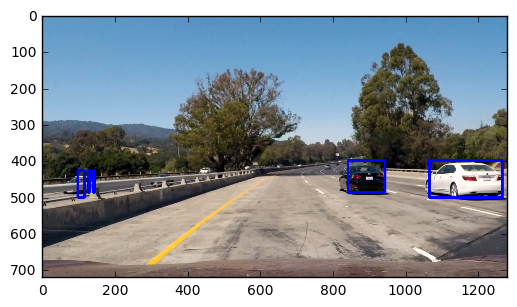

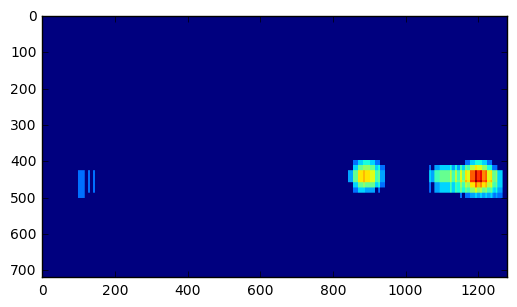

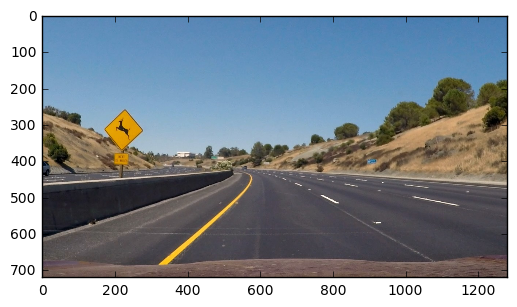

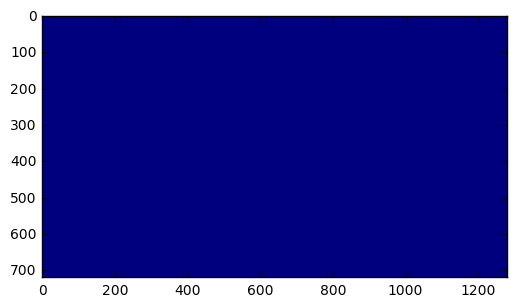

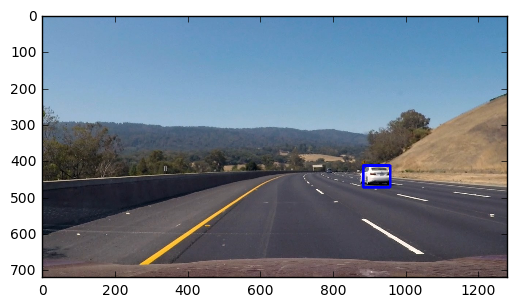

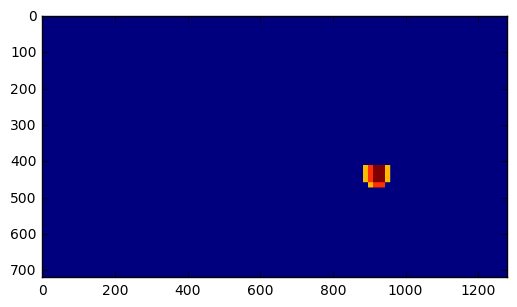

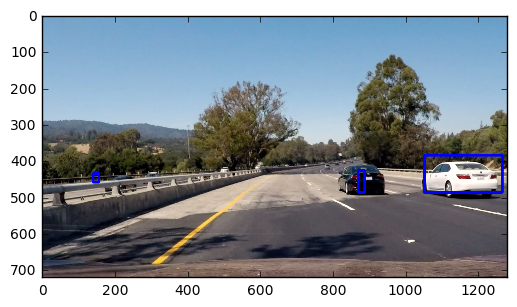

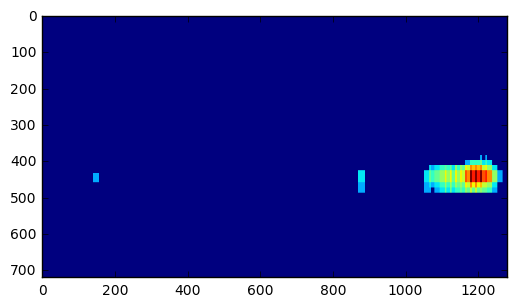

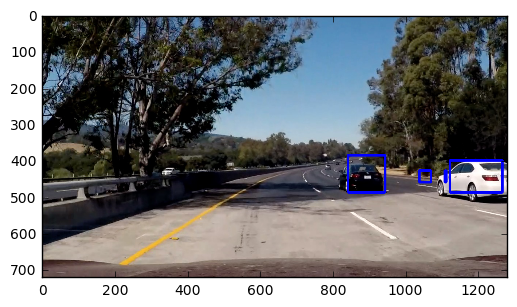

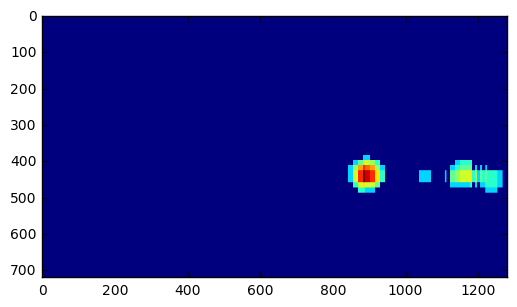

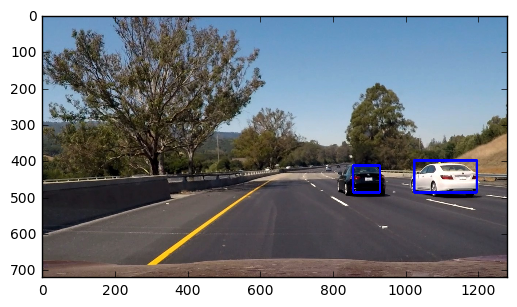

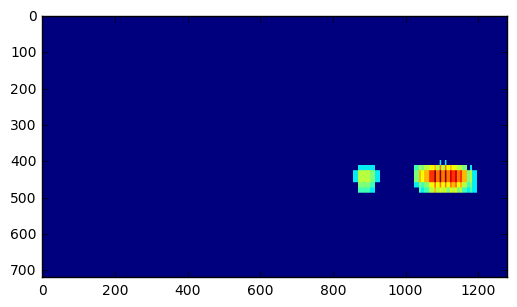

In [13]:
X_scaler = pickle.load(open("scalar.pkl", "rb"))
svm = joblib.load("svm.pkl")

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64)  # Spatial binning dimensions
hist_bins = 64  # Number of histogram bins
spatial_feat = False  # Spatial features on or off
hist_feat = False  # Histogram features on or off
hog_feat = True  # HOG features on or off


images = glob.glob("test_images/*")
for file in images:
    image = mpimg.imread(file)
    window_img,heatmap = detect_vehicles(image)
    plt.imshow(window_img)
    plt.show()
    plt.imshow(heatmap)    
    plt.show()


In [24]:
import imageio
from imageio.plugins import ffmpeg

imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

imageHolder = ImageHolder()

white_output = 'output_p2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(finalProcessImg) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video output_p2.mp4
[MoviePy] Writing video output_p2.mp4


100%|█████████▉| 1260/1261 [1:24:31<00:04,  4.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_p2.mp4 

CPU times: user 1h 23min 41s, sys: 37.9 s, total: 1h 24min 19s
Wall time: 1h 24min 32s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))